# FPL Prediction: EDA

Notebook used to explore and visualise FPL data for the prediction of weekly player points

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.configs.data_config import IDENTIFIERS, REALS, CATEGORIES, TARGET

## Data Overview

Show information relating to data counts, columns and types...

In [2]:
fpl_data = pd.read_csv('./data/interim/raw.csv',index_col=0)
fpl_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87452 entries, 0 to 87451
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           87452 non-null  int64  
 1   element       87452 non-null  int64  
 2   season        87452 non-null  object 
 3   name          87452 non-null  object 
 4   fixture       87452 non-null  int64  
 5   GW            87452 non-null  int64  
 6   value         87452 non-null  int64  
 7   bps           87452 non-null  int64  
 8   influence     87452 non-null  float64
 9   creativity    87452 non-null  float64
 10  threat        87452 non-null  float64
 11  ict_index     87452 non-null  float64
 12  minutes       87452 non-null  int64  
 13  fdr_player    87452 non-null  int64  
 14  fdr_diff      87452 non-null  int64  
 15  position      87452 non-null  object 
 16  was_home      87452 non-null  bool   
 17  total_points  87452 non-null  int64  
dtypes: bool(1), float64(4), in

For the purposes of timeseries modelling, we can broadly seperate these features across several dimensions:

Time:
1. **TIME_VARYING**: Does the feature vary accoding to past or future timesteps
    or
2. **STATIC**: Is the feature constant across time

Data availability:
1. **KNOWN**: Do we have access to past and future information relating to the feature
    or
2. **UNKNOWN**: Only past information is known about the feature

Data Type
1. **REAL**: Continuous values that require scaling.
    or
2. **CATEGORICAL**: Requires label/one-hot encoding

We can classigify the FPL features as the following

In [3]:
from src.configs.data_config import TIME_VARYING_UNKNOWN_REALS,TIME_VARYING_UNKNOWN_CATEGORICALS, TIME_VARYING_KNOWN_REALS,STATIC_REALS,STATIC_CATEGORICALS,TIME_VARYING_KNOWN_CATEGORICALS,TARGET

print(f"TIME_VARYING_UNKNOWN_REALS:{TIME_VARYING_UNKNOWN_REALS}",f"TIME_VARYING_KNOWN_REALS:{TIME_VARYING_KNOWN_REALS}" ,\
    f"TIME_VARYING_UNKNOWN_CATEGORICALS:{TIME_VARYING_UNKNOWN_CATEGORICALS}",f"TIME_VARYING_KNOWN_CATEGORICALS:{TIME_VARYING_KNOWN_CATEGORICALS}",\
    f"STATIC_REALS:{STATIC_REALS}",f"STATIC_CATEGORICALS:{STATIC_CATEGORICALS}",\
    f"TARGET:{TARGET}",sep='\n')

TIME_VARYING_UNKNOWN_REALS:['bps', 'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points', 'value']
TIME_VARYING_KNOWN_REALS:['fdr_player', 'fdr_diff']
TIME_VARYING_UNKNOWN_CATEGORICALS:[]
TIME_VARYING_KNOWN_CATEGORICALS:['was_home']
STATIC_REALS:[]
STATIC_CATEGORICALS:['position']
TARGET:['total_points']


Here is the dirstibution of our target variable (y) total points:

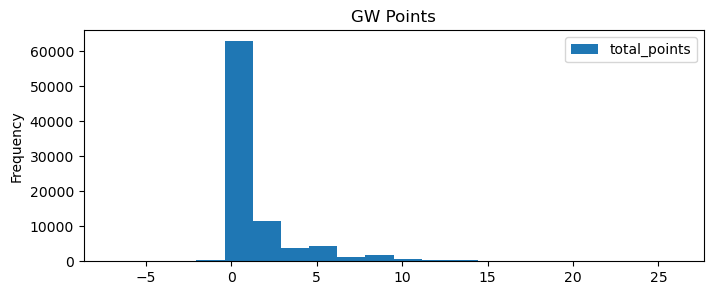

In [4]:
fpl_data[TARGET].plot.hist(bins=20,figsize=(8,3),title="GW Points")
plt.show()

Here is a bit of backgroind on the continuous input features (X):

In [5]:
fpl_data.loc[:,REALS].describe()

,value,bps,influence,creativity,threat,ict_index,minutes,fdr_player,fdr_diff
count,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000
mean,51.424656,5.904931,7.155701,4.688437,5.367630,1.720276,32.196473,2.952866,0.015380
std,12.312933,9.647543,12.788871,10.616842,13.573716,3.035137,40.581256,0.915772,1.327307
min,37.000000,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-3.000000
25%,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-1.000000
50%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,55.000000,10.000000,10.800000,2.500000,2.000000,2.500000,90.000000,4.000000,1.000000
max,136.000000,99.000000,144.000000,136.200000,181.000000,35.800000,90.000000,5.000000,3.000000


And here is an example of the type of the data for a single player for in a single season.

We would like to predict the total points (top plot) for all remaining games of the season using relevant input features:

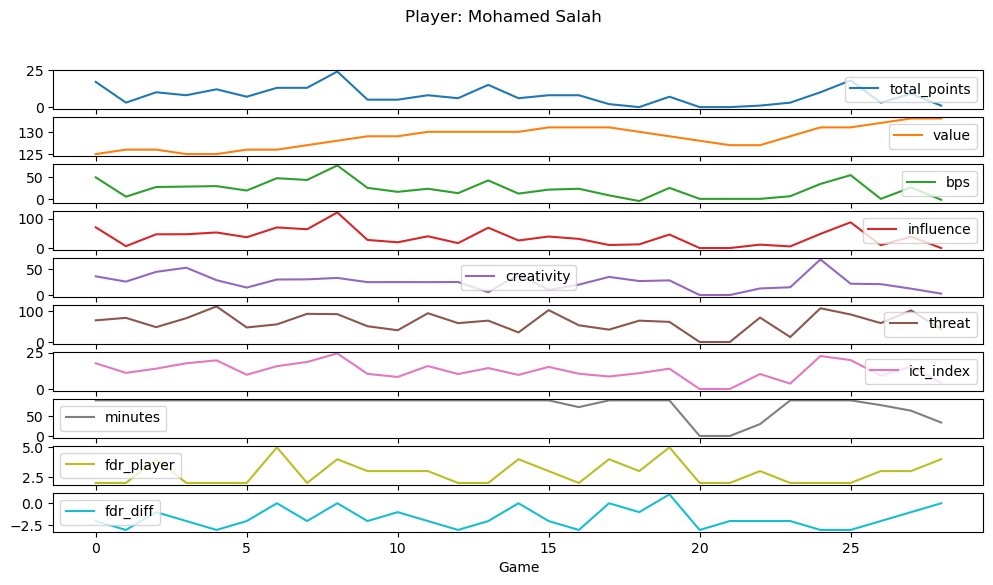

In [6]:
def plot_example(uid=None):
    """Function to sample random player/season and plot contuninuous vals"""

    #Sample if no uid provided
    if uid==None:
        print('Random choice selected')
        uid = fpl_data.uid.drop_duplicates().sample(1).values[0]

    player_details = fpl_data[lambda x: x.uid==uid].head(1).loc[:,['name','season']]
    fpl_data.loc[fpl_data.uid==uid,TARGET+REALS].reset_index(drop=True).\
                        plot(subplots=True,xlabel='Game',title=f"Player: {player_details.name.values[0]}",figsize=(12,6))
    plt.show()

plot_example(uid=233202122)

We are only really interested in players that could be considered candidates for inclusion in a fantasy football team.

There are however many players in the raw data who play little or at all i.e. youth and reserve players.

The below plots show the total points of the season.


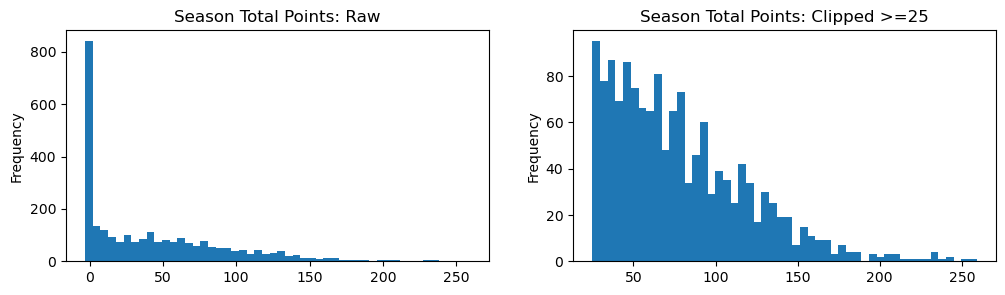

In [7]:
fig,axs = plt.subplots(1, 2,figsize = (12,3))
fpl_data.groupby('uid').sum().total_points.plot.hist(bins=50,ax=axs[0],title='Season Total Points: Raw')
fpl_data.groupby('uid').sum().total_points[lambda x:x>=25].plot.hist(bins=50,ax=axs[1],title='Season Total Points: Clipped >=25')
plt.show()

We can remove these players from the population using the below filter for the remaining analysis

In [8]:
points_ge25 = fpl_data.groupby('uid')['total_points'].transform(lambda x:x.sum()>=25)

## Correlations

We can review the correlation coefficients to quickly get a feel for the relevance of the continuous features.

In [9]:
# Function to extact grouped cross correlations
from src.data.feature_processing import crosscorr

The below plot shows the correlations (Spearman) going back 30 lags.

The incremental correlation appears to flatten after ~12 lags for most variables that demonstrate dynamic dependencies.

The correlation for the variables'value', 'fdr_diff' and 'fdr_player' remain constant. Since this data is also availabile in the future, this may suggest we do not require historic data.

We validate this in the next feature importance section

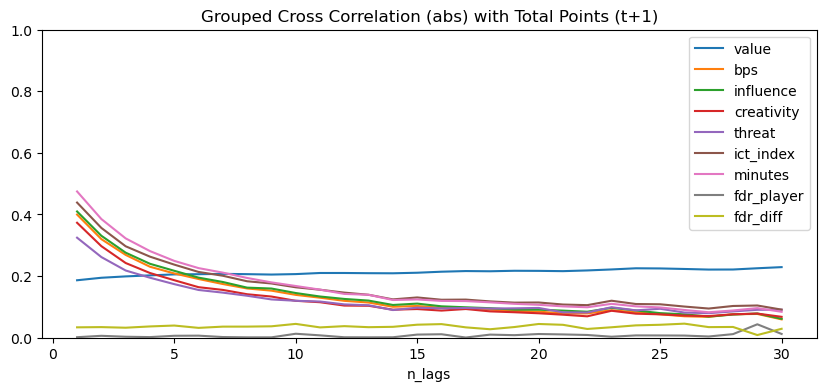

In [10]:
n_lags=30
corr_df = pd.DataFrame(index=list(range(1,n_lags+1)))
for col in REALS:
  corr_df[col] = [crosscorr(data=fpl_data[points_ge25],x_col=col,y_col='total_points', lag=i) for i in range(1,n_lags+1)]

corr_df.abs().plot(title='Grouped Cross Correlation (abs) with Total Points (t+1)',xlabel='n_lags',figsize=(10,4),ylim=(0,1))
plt.show()

Here are the correlations for the static features that are either static, or, we will have future information about

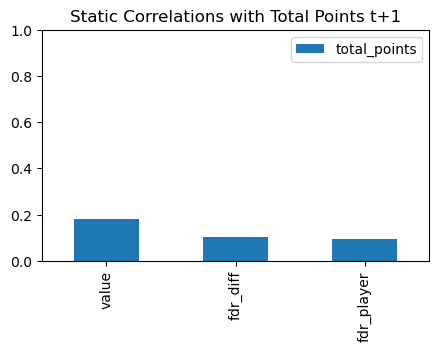

In [11]:
fpl_data.loc[points_ge25,['total_points','value','fdr_player','fdr_diff']].corr('spearman')[TARGET].abs()\
        .drop(TARGET,axis=0)\
            .sort_values(TARGET,ascending=False)\
                .plot.bar(ylim=(0,1),title='Static Correlations with Total Points t+1',figsize=(5,3))
plt.show()

## Feature Importance

While correlations give a quick insight, they do not accomodate categorical features, or, indivate the relevance of features in the presence of other data.

This is something which can be achieved by inspecting modelled feature importances.

For this task, a linear Lasso regression is used which can shrink the covariates to zero. The model is alsosimple to train with very few hyper parameters and is ideal for a quick and dirty analysis.

While we would like to make multiple predictions into the future, for this task, a single-step appraoch is used to keep it simple.

In [12]:
from src.data.feature_processing import gen_grouped_lagged_features

In [24]:
#Func to generate lags of features
from src.data.feature_processing import gen_grouped_lagged_features
n_lags = 20

time_varying_unknown_reals_X = gen_grouped_lagged_features(fpl_data.loc[points_ge25,TIME_VARYING_UNKNOWN_REALS+['uid']],group_col='uid',n_lags=n_lags)
TIME_VARYING_UNKNOWN_REALS_TRANSFORMED = time_varying_unknown_reals_X.columns.values.tolist()

time_varying_known_reals_X = gen_grouped_lagged_features(fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_REALS+['uid']],group_col='uid',n_lags=n_lags)
TIME_VARYING_KNOWN_REALS_TRANSFORMED = time_varying_known_reals_X.columns.values.tolist()

time_varying_known_categoricals_X = gen_grouped_lagged_features(fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_CATEGORICALS+['uid']],group_col='uid',n_lags=n_lags).astype('str')
TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED = time_varying_known_categoricals_X .columns.values.tolist()

lagged_cols = TIME_VARYING_UNKNOWN_REALS_TRANSFORMED+TIME_VARYING_KNOWN_REALS_TRANSFORMED+TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED


c:\Users\matth\OneDrive\Documents\FPL_Prediction\FPL_GameweekPrediction\src\data\feature_processing.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_X[f'{col}_l{lag}'] = df.groupby(group_col)[col].shift(lag)


In [25]:
X = fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_REALS+STATIC_REALS+STATIC_CATEGORICALS]
X = pd.concat([X,time_varying_unknown_reals_X,time_varying_known_reals_X,time_varying_known_categoricals_X ],axis=1)
#X.loc[:,STATIC_CATEGORICALS]=X.loc[:,STATIC_CATEGORICALS].astype(str)
#X = X.merge(time_varying_unknown_reals_X,how='left',left_index=True,right_index=True)
y= fpl_data.loc[points_ge25,TARGET]

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [49]:
#DYNAMIC DATA

numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant',fill_value=-100)),
       ('scaler',  StandardScaler())])

categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
       ('one_hot', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, TIME_VARYING_KNOWN_REALS+TIME_VARYING_KNOWN_REALS_TRANSFORMED+STATIC_REALS),
        ('cats', categorical_transformer, STATIC_CATEGORICALS+TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED)])


In [50]:
STATIC_CATEGORICALS+TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED

['position',
 'was_home_l1',
 'was_home_l2',
 'was_home_l3',
 'was_home_l4',
 'was_home_l5',
 'was_home_l6',
 'was_home_l7',
 'was_home_l8',
 'was_home_l9',
 'was_home_l10',
 'was_home_l11',
 'was_home_l12',
 'was_home_l13',
 'was_home_l14',
 'was_home_l15',
 'was_home_l16',
 'was_home_l17',
 'was_home_l18',
 'was_home_l19',
 'was_home_l20']

In [51]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression

model_pipe = Pipeline(steps=[('preprocessor',preprocessor),('regr',LassoCV(cv=5, random_state=0,max_iter=8000))]).fit(X,y)

C:\Users\matth\miniconda3\envs\pysam_env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [52]:
processor_names = TIME_VARYING_KNOWN_REALS+TIME_VARYING_KNOWN_REALS_TRANSFORMED+STATIC_REALS+model_pipe['preprocessor'].transformers_[1][1]\
    ['one_hot'].get_feature_names(STATIC_CATEGORICALS+TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED).tolist()

In [53]:
importances = pd.Series(model_pipe['regr'].coef_,index=processor_names).abs().sort_values(ascending=False).rename("Importance")

In [54]:
importances

position_GKP        0.517235
fdr_diff            0.401667
position_DEF        0.208471
position_FWD        0.124077
position_MID        0.096495
                      ...   
fdr_player_l9       0.000000
fdr_diff_l20        0.000000
fdr_diff_l19        0.000000
fdr_diff_l17        0.000000
was_home_l20_nan    0.000000
Name: Importance, Length: 106, dtype: float64

In [60]:
TIME_VARYING_UNKNOWN_REALS_TRANSFORMED

['bps_l1',
 'bps_l2',
 'bps_l3',
 'bps_l4',
 'bps_l5',
 'bps_l6',
 'bps_l7',
 'bps_l8',
 'bps_l9',
 'bps_l10',
 'bps_l11',
 'bps_l12',
 'bps_l13',
 'bps_l14',
 'bps_l15',
 'bps_l16',
 'bps_l17',
 'bps_l18',
 'bps_l19',
 'bps_l20',
 'influence_l1',
 'influence_l2',
 'influence_l3',
 'influence_l4',
 'influence_l5',
 'influence_l6',
 'influence_l7',
 'influence_l8',
 'influence_l9',
 'influence_l10',
 'influence_l11',
 'influence_l12',
 'influence_l13',
 'influence_l14',
 'influence_l15',
 'influence_l16',
 'influence_l17',
 'influence_l18',
 'influence_l19',
 'influence_l20',
 'creativity_l1',
 'creativity_l2',
 'creativity_l3',
 'creativity_l4',
 'creativity_l5',
 'creativity_l6',
 'creativity_l7',
 'creativity_l8',
 'creativity_l9',
 'creativity_l10',
 'creativity_l11',
 'creativity_l12',
 'creativity_l13',
 'creativity_l14',
 'creativity_l15',
 'creativity_l16',
 'creativity_l17',
 'creativity_l18',
 'creativity_l19',
 'creativity_l20',
 'threat_l1',
 'threat_l2',
 'threat_l3',
 'thr

In [58]:
importances.loc[TIME_VARYING_UNKNOWN_REALS_TRANSFORMED].to_frame()

KeyError: "None of [Index(['bps_l1', 'bps_l2', 'bps_l3', 'bps_l4', 'bps_l5', 'bps_l6', 'bps_l7',\n       'bps_l8', 'bps_l9', 'bps_l10',\n       ...\n       'value_l11', 'value_l12', 'value_l13', 'value_l14', 'value_l15',\n       'value_l16', 'value_l17', 'value_l18', 'value_l19', 'value_l20'],\n      dtype='object', length=160)] are in the [index]"

In [48]:
importances

position_GKP        0.517235
fdr_diff            0.401667
position_DEF        0.208471
position_FWD        0.124077
position_MID        0.096495
                      ...   
fdr_player_l9       0.000000
fdr_diff_l20        0.000000
fdr_diff_l19        0.000000
fdr_diff_l17        0.000000
was_home_l20_nan    0.000000
Name: Importance, Length: 106, dtype: float64

In [46]:
importances.loc[TIME_VARYING_UNKNOWN_REALS_TRANSFORMED]

KeyError: "None of [Index(['bps_l1', 'bps_l2', 'bps_l3', 'bps_l4', 'bps_l5', 'bps_l6', 'bps_l7',\n       'bps_l8', 'bps_l9', 'bps_l10',\n       ...\n       'value_l11', 'value_l12', 'value_l13', 'value_l14', 'value_l15',\n       'value_l16', 'value_l17', 'value_l18', 'value_l19', 'value_l20'],\n      dtype='object', length=160)] are in the [index]"

In [57]:
def plot_feature_importance():
    import matplotlib.ticker as ticker
    fig,axs = plt.subplots(1, 2,figsize = (12,5),sharey=True)
    time_varying_unknown_reals_importances = importances.loc[TIME_VARYING_KNOWN_REALS_TRANSFORMED].to_frame()
    time_varying_unknown_reals_importances['lag'] = time_varying_unknown_reals_importances.index.str.split('_').str[-1]
    time_varying_unknown_reals_importances['lag']  = time_varying_unknown_reals_importances['lag'].str.extract('(\d+)').astype(int)
    time_varying_unknown_reals_importances['feature'] = time_varying_unknown_reals_importances.index.str.split('_').str[:-1].str.join('_')
    time_varying_unknown_reals_importances = time_varying_unknown_reals_importances.sort_values(by=['lag']).reset_index(drop=True)
    time_varying_unknown_reals_importances = time_varying_unknown_reals_importances.set_index(['lag','feature']).unstack().rolling(5,min_periods=1).mean()
    time_varying_unknown_reals_importances.columns = time_varying_unknown_reals_importances.columns.droplevel()
    importance_order = time_varying_unknown_reals_importances.max().sort_values(ascending=False).index
    time_varying_unknown_reals_importances.loc[:,importance_order].plot(ax=axs[0],title='Time Varying Importance')
    axs[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    start, end = axs[0].get_xlim()
    axs[0].xaxis.set_ticks(np.arange(start, end, 1))
    axs[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

    current_and_future_importances = importances.loc[TIME_VARYING_KNOWN_REALS+STATIC_REALS+model_pipe['preprocessor'].transformers_[1][1]\
    ['one_hot'].get_feature_names(STATIC_CATEGORICALS).tolist()].to_frame()
    current_and_future_importances.sort_values(by='Importance',ascending=False).plot.bar(ax=axs[1],title='Static & Future Importance',legend=False)
    fig.tight_layout()
    plt.show()

plot_feature_importance()


ValueError: input_features should have length equal to number of features (21), got 1